In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle



In [2]:
from typing import Union
from collections.abc import Callable
from functools import partial

from ipynb.fs.defs.rk4 import rk4, euler_forward
from ipynb.fs.defs.awareness import susceptibility, g2, awareness_SIR

In [3]:
"""
data structure  data[i, j, k, m],
with i and j describing the place on the grid,
k=S,I,R and m=x0, x1, x2, ... (awareness)
"""

'\ndata structure  data[i, j, k, m],\nwith i and j describing the place on the grid,\nk=S,I,R and m=x0, x1, x2, ... (awareness)\n'

In [4]:
p_model = None
def simulate_rk4(model: Callable[[float, np.ndarray], np.ndarray], y0: np.ndarray, params: dict, tmax: float, dt: float=0.1, fname='test_data.txt')->None:
    n = int(tmax/dt)
    print(params)
    p_model = partial(model, **params)
    t, y = rk4(p_model, y0, 0, tmax, n)
    data = (t, y)
    with open(fname, "wb+") as f:
        pickle.dump(data, f)
    


In [5]:
y0 = np.zeros(shape=(30,30,3,5))  # start parameters,
                                  # size determines grid size and number of information compartments
#print(y0)
y0[:,:,0,-1] = 1  # everyone is susceptible, no information at the start


y0[14, 14, 1, -1] = 1  # one infection
y0[14, 14, 0, -1] = 0  # remove infected from susceptible pool


# to replicate information plot use instead:
#y0 = np.zeros(shape=(30,30,3,5))
#y0[:,:,0,-1] = 1  # everyone is susceptible, no information at the start
#y0[14, 14, 0, 0] = 1  # one information
#y0[14, 14, 0, -1] = 0  # remove spot with no information


# model
# alpha: awareness transmission
# beta: virus transmission
# gamma: virus recovery rate
# omega: awareness creation
# lam: awareness fading over time
# rho: susceptibility reduction (rh0=0.9 means 90% reduction for first level, 81% reduction for second level etc.)

parameters = dict(alpha=5, beta=0.25, gamma=0.2, omega=0.4, lam=0.5, rho=0.7)
tmax = 50
dt = 0.1

simulate_rk4(awareness_SIR, y0, parameters, tmax, dt)



{'alpha': 5, 'beta': 0.25, 'gamma': 0.2, 'omega': 0.4, 'lam': 0.5, 'rho': 0.7}


In [6]:
def load_data(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    t, y = data
    return t, y


In [7]:

model = partial(awareness_SIR, **parameters)
print(parameters)
#model = partial(awareness_SIR, alpha=5, beta=0.25, gamma=0.2, omega=0.4, lam=10, rho=RHO)


t_old, y_old = rk4(model,y0, 0, tmax, 10*tmax)
#t,y = rk4(model,y0,0,2,100)

# TODO: dy[target, 1, :] does NOT work, use
# dy[(*target, *np.s_[1, :])] or dy[(*target, np.s_[1], np.s_[:])] instead  -> is this now unreadable?
# alternatively use dy[target][..., 1, :]
# will get this working by monday - N.

{'alpha': 5, 'beta': 0.25, 'gamma': 0.2, 'omega': 0.4, 'lam': 0.5, 'rho': 0.7}


In [8]:
t_new, y_new = load_data('test_data.txt')

In [12]:
new = False
if new:
    t, y = t_new, y_new
else:
    t, y, = t_old, y_old

probability conserved: True
0.1353759794989382


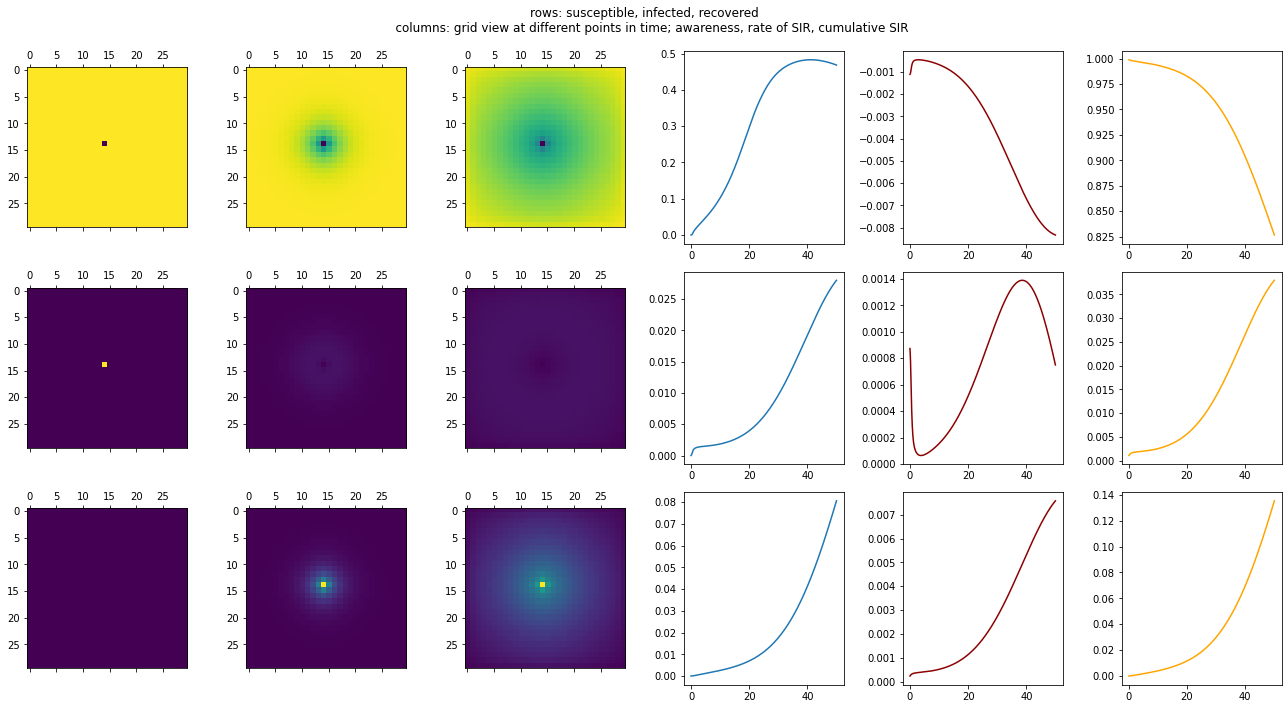

In [13]:
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(3, 6).reshape(3, 6)
SIR = np.sum(y, axis=3)  # sum over awareness axis, new axes: i, j, SIR, time
S = SIR[:, :, 0]
I = SIR[:, :, 1]
R = SIR[:, :, 2]
for i in range(3):
    aw = np.average(y[:, :, i, :], axis=(0, 1))  # average over grid, susceptible only -> indices: awareness
    awareness_level = g2(parameters['rho'], aw)
    axes[i, 3].plot(t, awareness_level)

    n = np.average(SIR[:, :, i], axis=(0, 1))
    axes[i, 5].plot(t, n, 'orange')

    dt = t[1:]-t[:-1]
    dn = n[1:]-n[:-1]
    t_av = 0.5*(t[1:]+t[:-1])
    axes[i, 4].plot(t_av, dn/dt, 'darkred')

kwargs = {
    'interpolation': 'nearest',
    'vmin': 0,
    'vmax': 1
}
print(f'probability conserved: {np.array([np.sum(y[i, j], axis=(0, 1)).all() for i in range(y.shape[0]) for j in range(y.shape[1])]).all()}')
m = int(S.shape[-1]/2)
axes[0, 0].matshow(S[..., 0], **kwargs)
axes[0, 1].matshow(S[..., m], **kwargs)
axes[0, 2].matshow(S[...,-1], **kwargs)
axes[1, 0].matshow(I[..., 0], **kwargs)
axes[1, 1].matshow(I[..., m], **kwargs)
axes[1, 2].matshow(I[...,-1], **kwargs)
axes[2, 0].matshow(R[..., 0], **kwargs)
axes[2, 1].matshow(R[..., m], **kwargs)
axes[2, 2].matshow(R[...,-1], **kwargs)

fig.suptitle('rows: susceptible, infected, recovered\n\
    columns: grid view at different points in time; awareness, rate of SIR, cumulative SIR')

#n = np.average(SIR[:, :, 2], axis=(0, 1))
#print(n[-1])

fig.tight_layout()
fig.savefig('figure.png', transparent=False)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac0f8ce2-3132-47be-a4d1-6216636e93ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>